# Final Project in Text Analysis and Natural Language Processing

### Title: Predicting financial risk using NLP, a sentiment and entity based approach

#### Table of contents:


<a href='#web_scrape'>1. Webscraping the data from the Google News </a><br>
    
<a href='#data_cleaning'>2. Text Cleaning & Deduplication</a>

<a href='#text_pre'>3. Text Preprocessing</a>	

<a href='#sent_ana'>4. Sentiment Analysis with VADER </a>

<a href='#fin_ana'>5. Sentiment Analysis with FinBERT </a>

<a href='#Sen_Comp'>6. Comparison of Sentiments: VADER vs FinBert </a>

<a href='#name_reco'>7. Named Entity Recognition (NER) </a>

<a href='#top_mod'>8. Topic Modeling: Understanding Market Conversations </a>

<a href='#stock_corr'>9. Stock Price Data Collection and Sentiment Correlation </a>

### Importing the needed libraries

Here we are importing the libraries that I will be needing for the further analysis:

In [ ]:
#Importing libraries to scrap
#from serpapi import GoogleSearch

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import re

# Importing libraries for text preprocossing 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Importing library for VADAR Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#importin libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Importing library for FinBERT Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
from tqdm import tqdm
import requests

## Importing library for NER
import spacy
from collections import Counter

# In order to ignore the warnings, not show the warnings in the code output
import warnings
warnings.filterwarnings("ignore")

# Imporint library for Topic Modeling
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# importing library for Stock comparison
import yfinance as yf




c:\Users\Mustafa Ansari\finbert_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Webscraping the data from the Independent newspaper <a id='web_scrape'></a>

In this code snippet i have tried to scrap recent financial news headlines and a short description of the news using SerpAPI (Google News API) for the following companies:

- Apple
- Tesla
- Nvidia
- Amazon

The objective is to retrieve high-quality, recent news headlines and snippets (within the last 90 days) that can be used for further Sentiment analysis, Entity recogntion and Risk Scoring. 

In [4]:
# Step 1: Your SerpAPI Key
API_KEY = "--"

# Step 2: Parse Relative/Absolute Dates
def parse_relative_date(text):
    today = datetime.today()
    try:
        if re.search(r"\w{3,} \d{1,2}, \d{4}", text):  # e.g. Apr 4, 2025
            return datetime.strptime(text, "%b %d, %Y")
        elif "day" in text:
            days = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(days=days)
        elif "hour" in text:
            hours = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(hours=hours)
        elif "week" in text:
            weeks = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(weeks=weeks)
        elif "month" in text:
            months = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(days=30 * months)
        else:
            return None
    except:
        return None

# Step 3: Scraper Function
def scrape_serpapi_news(company, target_articles=600):
    print(f"🔍 Scraping {company}...")
    results = []
    page = 0
    collected = 0
    today = datetime.today()
    ninety_days_ago = today - timedelta(days=90)

    while collected < target_articles:
        params = {
            "engine": "google",
            "q": f"{company} stock",
            "tbm": "nws",
            "api_key": API_KEY,
            "num": 100,
            "start": page * 100,
            "tbs": "cdr:1,cd_min:1/14/2024,cd_max:4/14/2025"
        }

        search = GoogleSearch(params)
        response = search.get_dict()
        news_results = response.get("news_results", [])

        if not news_results:
            print(f"⚠️ No more news results found at page {page} for {company}")
            break

        for article in news_results:
            pub_date_raw = article.get("date")
            parsed_date = parse_relative_date(pub_date_raw)

            if parsed_date and parsed_date >= ninety_days_ago:
                results.append({
                    "company": company,
                    "title": article.get("title"),
                    "link": article.get("link"),
                    "snippet": article.get("snippet"),
                    "source": article.get("source"),
                    "published": parsed_date.strftime("%m/%d/%Y")
                })

        collected = len(results)
        page += 1
        time.sleep(1)

    print(f"Collected {len(results)} valid articles for {company}")
    return pd.DataFrame(results[:target_articles])

# Step 4: List of Companies
companies = ["Apple", "Tesla", "Nvidia", "Amazon"]

# Step 5: Scrape & Save
all_dfs = []
for company in companies:
    df = scrape_serpapi_news(company, target_articles=600)
    all_dfs.append(df)

final_df = pd.concat(all_dfs, ignore_index=True)

🔍 Scraping Apple...


NameError: name 'GoogleSearch' is not defined

### Reading the data

For confidentiality purposes, i have hidden my API and have uploaded and read the data below:

In [5]:
final_df = pd.read_csv("C:\\Users\\Mustafa Ansari\\Downloads\\Scrapped Google News.csv")

In [6]:
final_df.head()

,company,title,link,snippet,source,published
0,Apple,Where Will Apple Stock Be In 5 Years?,https://www.forbes.com/sites/investor-hub/arti...,The shares currently trade approximately 12% b...,Forbes,03/15/2025
1,Apple,Apple Joins AI Data Center Race After Siri Mess,https://www.investors.com/news/technology/appl...,Apple is in the process of placing orders for ...,Investor's Business Daily,03/24/2025
2,Apple,How Bad Could Sustained Tariffs Be for Apple S...,https://www.morningstar.com/stocks/how-bad-cou...,"If tariffs persist, Apple's profit margins cou...",Morningstar,04/09/2025
3,Apple,Analysts revisit Apple stock price targets as ...,https://www.thestreet.com/investing/analysts-r...,"Wedbush analyst Dan Ives, a committed Apple bu...",TheStreet,03/24/2025
4,Apple,Watch These Apple Stock Price Levels Amid Tari...,https://www.investopedia.com/watch-these-apple...,Apple shares gained ground Wednesday after los...,Investopedia,04/09/2025


## Text Cleaning & Deduplication <a id='data_cleaning'></a>

In this step, i have firstly combined title and snippet into a single column: text then dropped exact duplicates of combined text and dropped nulls and whitespace-only entries. Finally i have reset index for tidy output.

In [7]:
# Original Data
original_count = len(final_df)
df = final_df.copy()

# STEP 1: Combine title + snippet
df["text"] = df["title"].fillna("") + ". " + df["snippet"].fillna("")

# STEP 2: Remove short/empty text
df["text"] = df["text"].str.strip()
before_empty_filter = len(df)
df = df[df["text"].str.len() > 10]
after_empty_filter = len(df)
empty_dropped = before_empty_filter - after_empty_filter

# STEP 3: Remove exact duplicates
before_dedup = len(df)
df = df.drop_duplicates(subset=["text"])
after_dedup = len(df)
duplicates_dropped = before_dedup - after_dedup

# STEP 4: Reset index
df = df.reset_index(drop=True)

# Save cleaned version
df.to_csv(r"C:\Users\Mustafa Ansari\Downloads\news_cleaned_deduplicated.csv", index=False)


In [8]:
# Summary
print("Cleaning Summary:")
print(f"• Original articles: {original_count}")
print(f"• Removed short/empty text: {empty_dropped}")
print(f"• Removed duplicates: {duplicates_dropped}")
print(f" Final cleaned articles: {len(df)}")

Cleaning Summary:
• Original articles: 1929
• Removed short/empty text: 0
• Removed duplicates: 146
 Final cleaned articles: 1783


In [9]:
df.head()

,company,title,link,snippet,source,published,text
0,Apple,Where Will Apple Stock Be In 5 Years?,https://www.forbes.com/sites/investor-hub/arti...,The shares currently trade approximately 12% b...,Forbes,03/15/2025,Where Will Apple Stock Be In 5 Years?. The sha...
1,Apple,Apple Joins AI Data Center Race After Siri Mess,https://www.investors.com/news/technology/appl...,Apple is in the process of placing orders for ...,Investor's Business Daily,03/24/2025,Apple Joins AI Data Center Race After Siri Mes...
2,Apple,How Bad Could Sustained Tariffs Be for Apple S...,https://www.morningstar.com/stocks/how-bad-cou...,"If tariffs persist, Apple's profit margins cou...",Morningstar,04/09/2025,How Bad Could Sustained Tariffs Be for Apple S...
3,Apple,Analysts revisit Apple stock price targets as ...,https://www.thestreet.com/investing/analysts-r...,"Wedbush analyst Dan Ives, a committed Apple bu...",TheStreet,03/24/2025,Analysts revisit Apple stock price targets as ...
4,Apple,Watch These Apple Stock Price Levels Amid Tari...,https://www.investopedia.com/watch-these-apple...,Apple shares gained ground Wednesday after los...,Investopedia,04/09/2025,Watch These Apple Stock Price Levels Amid Tari...


## Text Preprocessing <a id='text_pre'></a>

**In this section the following text preprocessing steps have been implemented:**

1.  Lowercasing

2. Remove punctuation & special characters

3.  Remove digits and extra whitespace

4. Tokenize text (split into words)

5. Remove stopwords (e.g., "the", "is", "of")

6. Lemmatize words (e.g., “running” → “run”)


In [75]:
# Download NLTK resources (one-time)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Setup
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs, special characters, digits
    text = re.sub(r"http\S+|www\S+|[^a-z\s]", " ", text)

    # 3. Tokenize
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # 5. Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # Return processed text as space-separated string
    return " ".join(tokens)

# Apply to all texts
df["text_clean"] = df["text"].apply(preprocess_text)

# Preview
print(df[["company", "text_clean"]].sample(3))



[nltk_data] Error loading punkt: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>
[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>


     company                                         text_clean
1685  Amazon  amazon nvidia billionaire buying one selling b...
1640  Amazon  amazon stock nasdaq amzn gain firing line good...
990   Nvidia  nvidia stock point key takeaway downturn nvda ...


## Sentiment Analysis with VADER <a id='sent_ana'></a>

To begin the sentiment analysis, we use **VADER (Valence Aware Dictionary and sEntiment Reasoner)** - a fast and interpretable rule-based model built specifically for short text like headlines or tweets.

VADER is ideal for our dataset because:
- It works well on finance-related headlines and snippets
- It provides a **compound score** between -1 (negative) and +1 (positive)
- It also returns **positive, neutral, and negative** proportions

We'll compute the compound score and assign a sentiment label:
- **Positive** if score ≥ 0.05  
- **Negative** if score ≤ -0.05  
- **Neutral** otherwise

In [76]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment score and label
def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        label = 'positive'
    elif compound <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    return pd.Series([compound, label])

# Apply to cleaned text
df[["vader_score", "vader_label"]] = df["text_clean"].apply(get_vader_sentiment)

# Preview
df[["company", "text_clean", "vader_score", "vader_label"]].sample(5)


,company,text_clean,vader_score,vader_label
1764,Amazon,amazon com inc nasdaq amzn share purchased smi...,0.9136,positive
792,Tesla,musk loses billion tesla share get hammered es...,0.4767,positive
920,Tesla,trump trade war china begin apple tesla stock ...,-0.5256,negative
891,Tesla,tech stock roundup tesla halt model order chin...,0.1531,positive
718,Tesla,president trump speaks reporter elon musk amid...,0.3612,positive


**Each row now includes two new columns:**

- `vader_score`: A numeric sentiment value between -1 (very negative) and +1 (very positive)
- `vader_label`: A human-readable classification based on the score:

  - **Positive** if score ≥ 0.05
  - **Negative** if score ≤ -0.05
  - **Neutral** if in between

For example:
- *A Tesla article with a score of **-0.63** is labeled **negative**, reflecting bearish tone.*
- *An Amazon headline scored **0.20** is labeled **positive**, indicating optimistic sentiment.*

This helps us quantify how financial news articles emotionally frame events and companies.


### VADER Sentiment Distribution by Company

To get an overview of sentiment trends, we group the sentiment labels by company and count how many headlines were classified as **positive**, **neutral**, or **negative**.



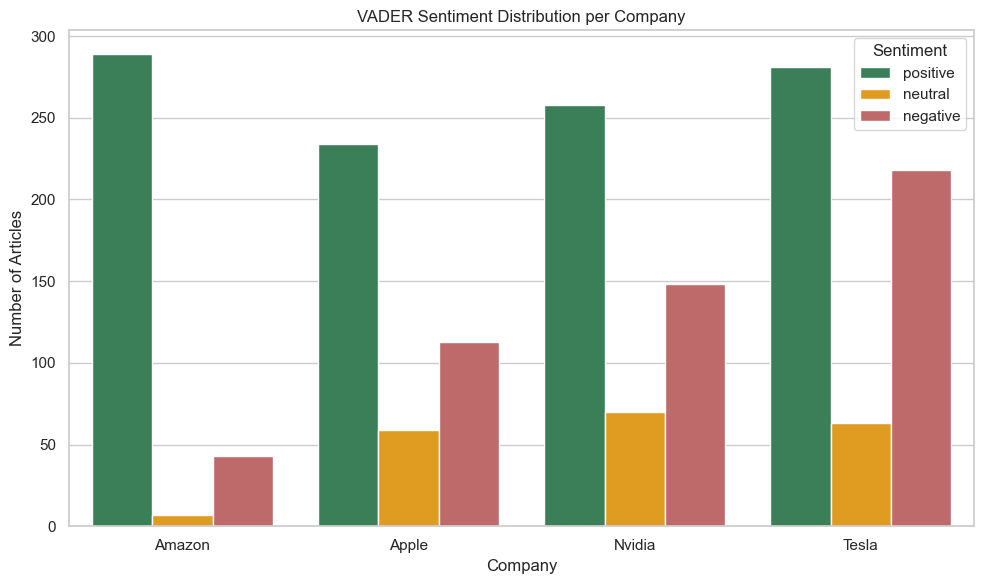

In [ ]:
# Set up plot style
sns.set(style="whitegrid")

# Group and count sentiments by company
sentiment_counts = df.groupby(["company", "vader_label"]).size().reset_index(name="count")

# Define label order
sentiment_order = ["positive", "neutral", "negative"]

# Define darker custom colors
custom_colors = {
    "positive": "#2E8B57",   
    "neutral": "#FFA500",    
    "negative": "#CD5C5C"    
}

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=sentiment_counts,
    x="company",
    y="count",
    hue="vader_label",
    hue_order=sentiment_order,
    palette=custom_colors
)

plt.title("VADER Sentiment Distribution per Company")
plt.xlabel("Company")
plt.ylabel("Number of Articles")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


- All companies show a strong presence of **positive sentiment** in their news coverage.
- **Tesla** and **Nvidia** received the most **negative headlines**, suggesting higher perceived risk or controversy.
- **Amazon** stands out with a very small number of neutral or negative headlines, possibly reflecting a more bullish or less volatile news cycle.
- **Apple** has a moderate distribution across all three sentiment classes.

This helps us understand how media tone varies between companies in the last 90 days and sets a baseline for comparing results with FinBERT next.


## Word Clouds by VADER Sentiment 

To explore how language differs across sentiment classes, I am generating word clouds for each sentiment label (positive, neutral, negative) using both VADAR results.

This helps us visualize the dominant vocabulary associated with different market tones and provides clues about how risk-related vs. opportunity-related terms are distributed across the financial headlines.

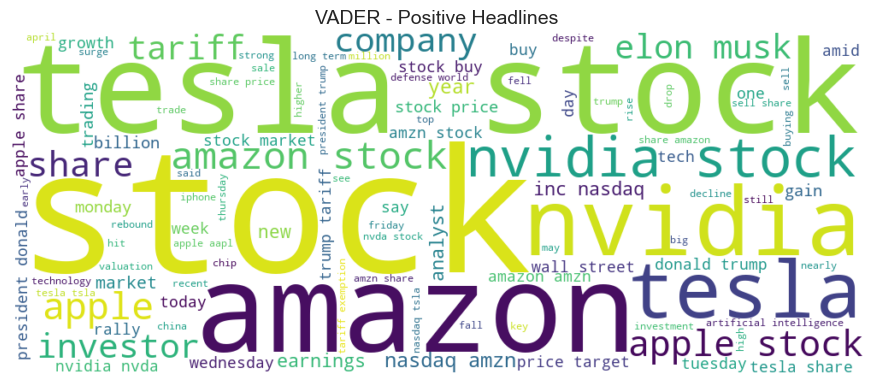

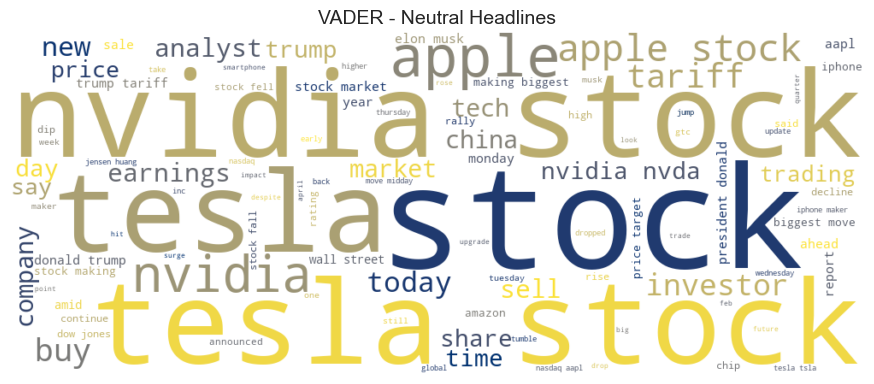

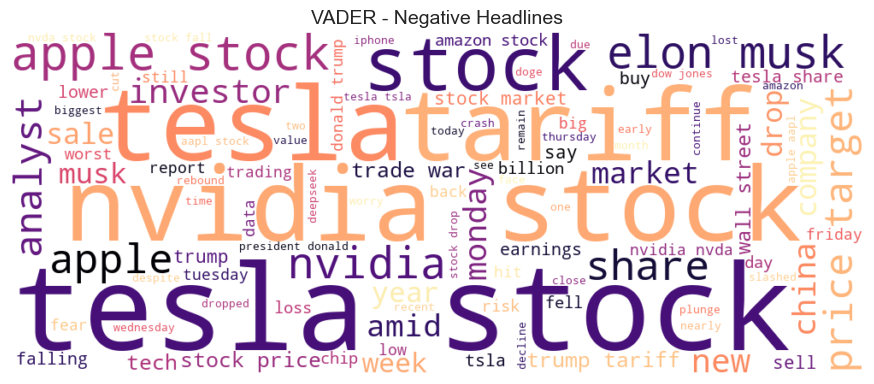

In [77]:
# Define a reusable function with dynamic colormap
def plot_wordcloud(text_data, title, colormap):
    text = " ".join(text_data)
    wordcloud = WordCloud(
        width=1000,
        height=400,
        background_color='white',
        colormap=colormap,
        max_words=100
    ).generate(text)
    plt.figure(figsize=(10, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Assign custom colormaps per sentiment
sentiment_colors = {
    'positive': 'viridis',
    'neutral': 'cividis',
    'negative': 'magma'
}

# Word Clouds for VADER sentiment
for sentiment in ['positive', 'neutral', 'negative']:
    subset = df[df['vader_label'] == sentiment]['text_clean']
    plot_wordcloud(subset, f"VADER - {sentiment.capitalize()} Headlines", sentiment_colors[sentiment])


## Sentiment Analysis with FinBERT <a id='fin_ana'></a>



To complement VADER, we use **FinBERT**, a transformer-based model trained on financial text. It understands deeper linguistic patterns and domain-specific language better than rule-based tools.

**Why FinBERT?**
- Trained specifically on financial documents
- Can capture subtle nuances (e.g., "missed earnings expectations")
- Outputs one of three labels: **positive**, **neutral**, or **negative**

We'll use the `transformers` library to load the pre-trained model and classify each headline/snippet.


In [71]:
# Enables progress_apply
tqdm.pandas() 

# Load FinBERT model
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set up pipeline
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Load your preprocessed file
df = pd.read_csv(r"C:\Users\Mustafa Ansari\Downloads\news_preprocessed.csv")
df = df[df["text_clean"].notnull()].copy()  # Ensuring no nulls

## Setup progress bar + sentiment function
def get_finbert_label(text):
    try:
        result = finbert(text[:512])[0]
        return result["label"].lower()
    except:
        return "error"

# Apply FinBERT
df["finbert_label"] = df["text_clean"].progress_apply(get_finbert_label)


# Preview
print(df["finbert_label"].value_counts())
df[["company", "text_clean", "finbert_label"]].sample(5)

Device set to use cpu
100%|██████████| 1783/1783 [03:05<00:00,  9.62it/s]

finbert_label
neutral     661
positive    620
negative    502
Name: count, dtype: int64


,company,text_clean,finbert_label
1341,Nvidia,nvidia stock still red hot buy post earnings d...,positive
1592,Amazon,amazon earnings deck stock climb back record t...,positive
1331,Nvidia,dear nvidia stock fan mark calendar february d...,positive
1188,Nvidia,nvidia stock dip ahead giant massive earnings ...,positive
957,Tesla,driver new car tech leave hell alone please to...,positive


### FinBert Sentiment Distribution by Company

To get an overview of sentiment trends, we group the sentiment labels by company and count how many headlines were classified as **positive**, **neutral**, or **negative**.

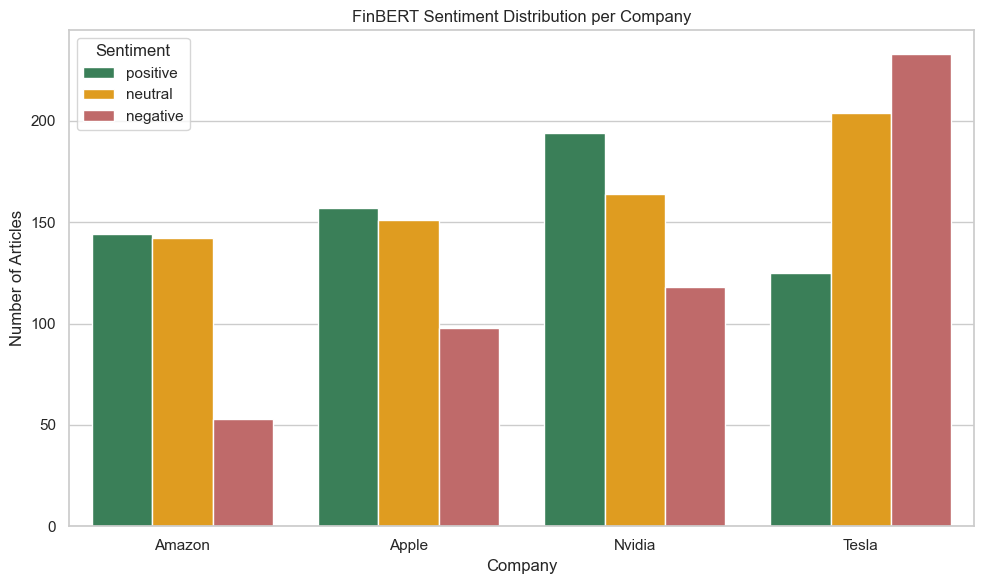

In [ ]:
# Set up plot style
sns.set(style="whitegrid")

# Group and count sentiments by company
finbert_sentiment_counts = df.groupby(["company", "finbert_label"]).size().reset_index(name="count")

# Define label order
sentiment_order = ["positive", "neutral", "negative"]

# Define darker custom colors
custom_colors = {
    "positive": "#2E8B57",   
    "neutral": "#FFA500",   
    "negative": "#CD5C5C"    
}

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=finbert_sentiment_counts,
    x="company",
    y="count",
    hue="finbert_label",
    hue_order=sentiment_order,
    palette=custom_colors
)

plt.title("FinBERT Sentiment Distribution per Company")
plt.xlabel("Company")
plt.ylabel("Number of Articles")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


- **Tesla** shows the **highest number of negative headlines**, indicating potentially riskier or more controversial media coverage in the financial domain.
- **Nvidia** also has a noticeable amount of **negative sentiment**, though positive sentiment remains dominant.
- **Apple** displays a well-balanced distribution across **positive**, **neutral**, and **negative** tones, reflecting diverse media narratives.
- **Amazon** has almost equal proportions of **positive** and **neutral** sentiment, with relatively low negativity - suggesting stable or less polarizing news.


## Word Clouds by FinBERT Sentiment 

To explore how language differs across sentiment classes, I am generating word clouds for each sentiment label (positive, neutral, negative) using both FinBERT results.

This helps us visualize the dominant vocabulary associated with different market tones and provides clues about how risk-related vs. opportunity-related terms are distributed across the financial headlines.

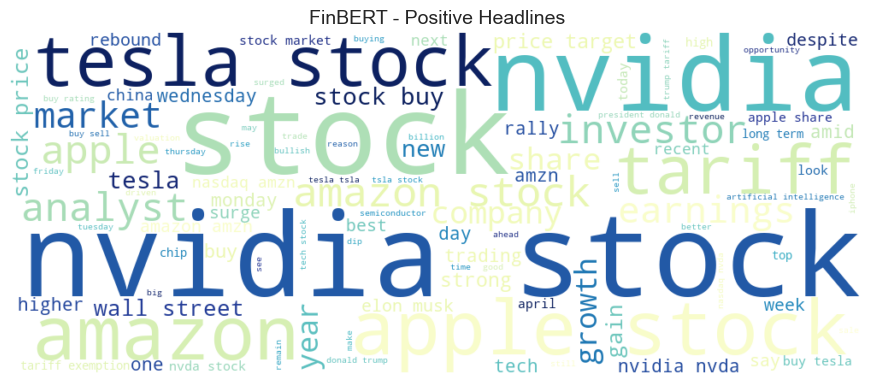

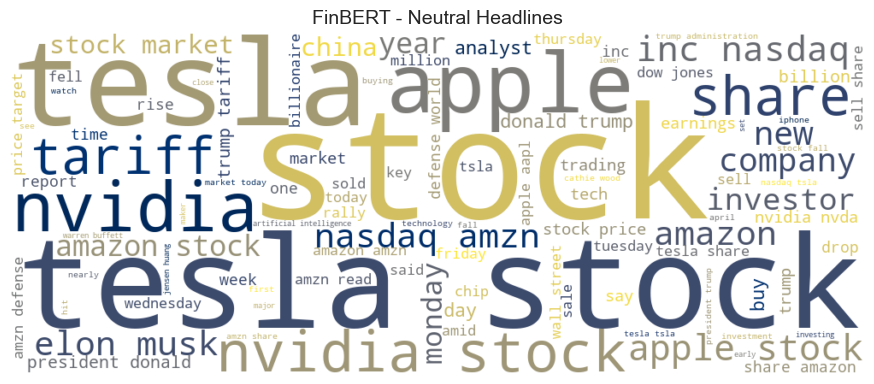

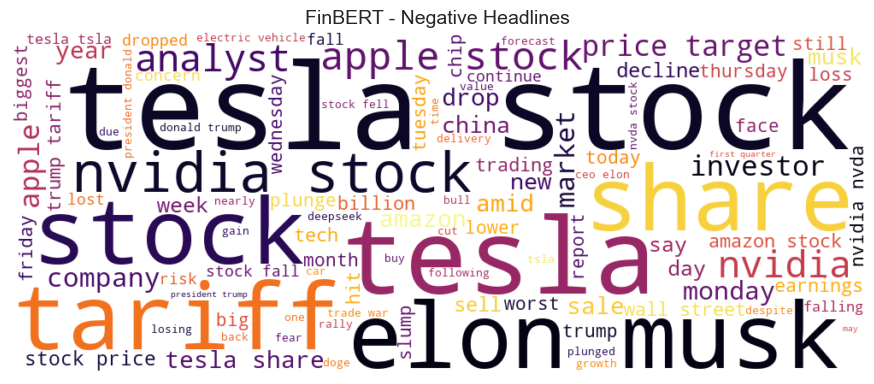

In [72]:
# Define custom colormap per sentiment
sentiment_colors = {
    'positive': 'YlGnBu',     
    'neutral': 'cividis',    
    'negative': 'inferno'        
}

# Define the reusable word cloud function
def plot_wordcloud(text_data, title, colormap):
    text = " ".join(text_data)
    wordcloud = WordCloud(
        width=1000, height=400,
        background_color='white',
        colormap=colormap,
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Generate word clouds for each FinBERT sentiment
for sentiment in ['positive', 'neutral', 'negative']:
    subset = df[df['finbert_label'] == sentiment]['text_clean']
    plot_wordcloud(
        subset,
        f"FinBERT - {sentiment.capitalize()} Headlines",
        sentiment_colors[sentiment]
    )


## Comparison of Sentiments: VADER vs FinBert <a id='Sen_Comp'></a>

Now that all financial news headlines are classified using both **VADER** and **FinBERT**, I would like to compare their sentiment predictions.

- **VADER** is a lexicon-based tool designed for social media and short text.
- **FinBERT** is a domain-specific transformer trained on financial texts.

This comparison highlights:
- How often the tools agree
- Where they differ (and possibly why)
- Overall sentiment distribution across models

### Sentiment Distribution Side-by-Side

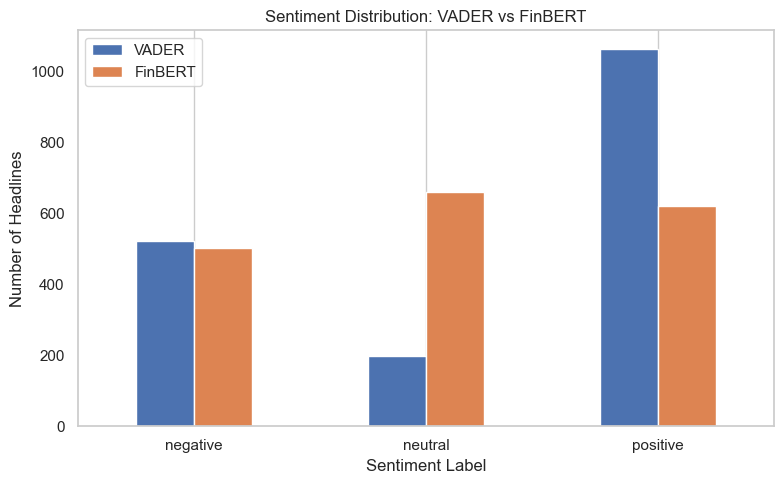

In [19]:
# Count sentiment labels
vader_counts = df["vader_label"].value_counts().sort_index()
finbert_counts = df["finbert_label"].value_counts().sort_index()

# Combine into one DataFrame for plotting
comparison_df = pd.DataFrame({
    "VADER": vader_counts,
    "FinBERT": finbert_counts
})

# Plot
comparison_df.plot(kind="bar", figsize=(8, 5), rot=0)
plt.title("Sentiment Distribution: VADER vs FinBERT")
plt.ylabel("Number of Headlines")
plt.xlabel("Sentiment Label")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


The bar chart above shows the overall sentiment distribution predicted by both VADER and FinBERT:

- **VADER** tends to classify a large majority of headlines as **positive**.
- **FinBERT**, in contrast, assigns more **neutral** labels and distributes sentiments more evenly.
- This highlights FinBERT's domain-specific calibration — it avoids being overly optimistic and is more conservative in financial sentiment judgment.


### Agreement/Disagreement Matrix

In [20]:
# Cross-tab to compare predictions
agreement = pd.crosstab(df["vader_label"], df["finbert_label"])

# Show it
print("VADER vs FinBERT Agreement Matrix:")
display(agreement)


VADER vs FinBERT Agreement Matrix:


finbert_label,negative,neutral,positive
vader_label,,,
negative,281,149,92
neutral,40,101,58
positive,181,411,470


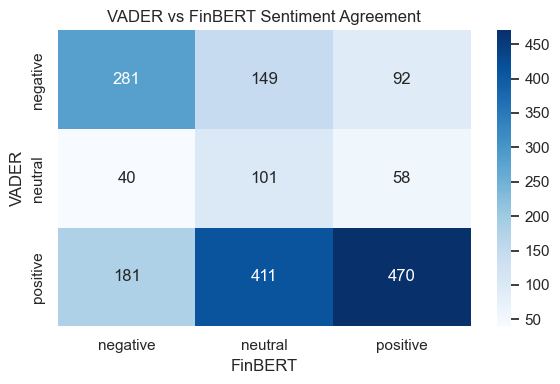

In [21]:
plt.figure(figsize=(6, 4))
sns.heatmap(agreement, annot=True, fmt='d', cmap="Blues")
plt.title("VADER vs FinBERT Sentiment Agreement")
plt.ylabel("VADER")
plt.xlabel("FinBERT")
plt.tight_layout()
plt.show()


Key takeaways:

- **470 headlines** were **labeled positive by both** VADER and FinBERT — showing high agreement.
- VADER labeled **181 headlines as positive** that FinBERT marked **as negative**, which may indicate over-optimism from VADER.
- FinBERT labeled **149 VADER-negative headlines as neutral**, suggesting FinBERT avoids extreme sentiment unless strongly implied.
- FinBERT appears more cautious and nuanced — more in line with financial tone expectations.

This comparison shows the importance of using a **domain-specific model like FinBERT** when dealing with financial sentiment analysis.

In [79]:
# Add a column to flag whether both models agree
df['sentiment_agreement'] = df['vader_label'] == df['finbert_label']

# Compute the overall agreement rate
agreement_rate = df['sentiment_agreement'].mean()
print(f"Sentiment Match Rate: {agreement_rate:.2%}")

Sentiment Match Rate: 47.78%


### Sentiment Disagreements percentage and sample

In [85]:
# Combine all sentiment summaries
sentiment_summary = df.groupby('company').apply(
    lambda x: pd.Series({
        'FinBERT Positive %': (x['finbert_label'] == 'positive').mean() * 100,
        'VADER Positive %': (x['vader_label'] == 'positive').mean() * 100,
        'FinBERT Neutral %': (x['finbert_label'] == 'neutral').mean() * 100,
        'VADER Neutral %': (x['vader_label'] == 'neutral').mean() * 100,
        'FinBERT Negative %': (x['finbert_label'] == 'negative').mean() * 100,
        'VADER Negative %': (x['vader_label'] == 'negative').mean() * 100
    })
).reset_index()

# Display clean DataFrame
print(sentiment_summary.round(2))


  company  FinBERT Positive %  VADER Positive %  FinBERT Neutral %  \
0  Amazon               42.48             85.25              41.89   
1   Apple               38.67             57.64              37.19   
2  Nvidia               40.76             54.20              34.45   
3   Tesla               22.24             50.00              36.30   

   VADER Neutral %  FinBERT Negative %  VADER Negative %  
0             2.06               15.63             12.68  
1            14.53               24.14             27.83  
2            14.71               24.79             31.09  
3            11.21               41.46             38.79  


In [22]:
# Show a few headlines where they disagreed

disagreements = df[df["vader_label"] != df["finbert_label"]]
disagreements[["company", "text_clean", "vader_label", "finbert_label"]].sample(5)


,company,text_clean,vader_label,finbert_label
935,Tesla,tesla rally fooled sight nasdaq tsla apr ettes...,negative,neutral
1199,Nvidia,cathie wood buy million tumbling nvidia stock ...,positive,neutral
1161,Nvidia,nvidia stock rise volatility coming nvidia sto...,negative,neutral
1184,Nvidia,tariff uncertainty still hanging nvidia stock ...,negative,positive
751,Tesla,tesla stock surging today tesla stock surging ...,positive,neutral


## Named Entity Recognition (NER) <a id='name_reco'></a>

We use `spaCy`'s transformer-based language model to extract **named entities** from each news headline.
This helps identify which organizations, people, or products are mentioned in each article and also to explore which entities are most frequently associated with positive or negative sentiment.


In [68]:
# Load the lightweight spaCy NER model
nlp = spacy.load("en_core_web_sm")

# Load your cleaned dataset
df = pd.read_csv(r"C:\Users\Mustafa Ansari\Downloads\news_preprocessed.csv")
df = df[df["text_clean"].notnull()].copy()

# Extract entities
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply to headlines
df["named_entities"] = df["text_clean"].progress_apply(extract_entities)

# Flatten and count entity labels
all_entities = [label for ents in df["named_entities"] for (_, label) in ents]
entity_freq = Counter(all_entities)

# Display top 10
print("Top 10 Named Entity Types:")
print(entity_freq.most_common(10))


100%|██████████| 1783/1783 [00:12<00:00, 141.66it/s]

Top 10 Named Entity Types:
[('DATE', 1296), ('ORG', 976), ('PERSON', 457), ('CARDINAL', 283), ('GPE', 234), ('NORP', 90), ('TIME', 79), ('ORDINAL', 68), ('LOC', 21), ('MONEY', 12)]


### Entity Frequency by Sentiment Label

To better understand the relationship between entities mentioned in headlines and the tone of the article, we count how often entities of each type appear under each sentiment class.This helps us detect patterns, such as:

1. Do headlines mentioning organizations tend to be more negative?

2. Are people often mentioned in positive or neutral contexts?

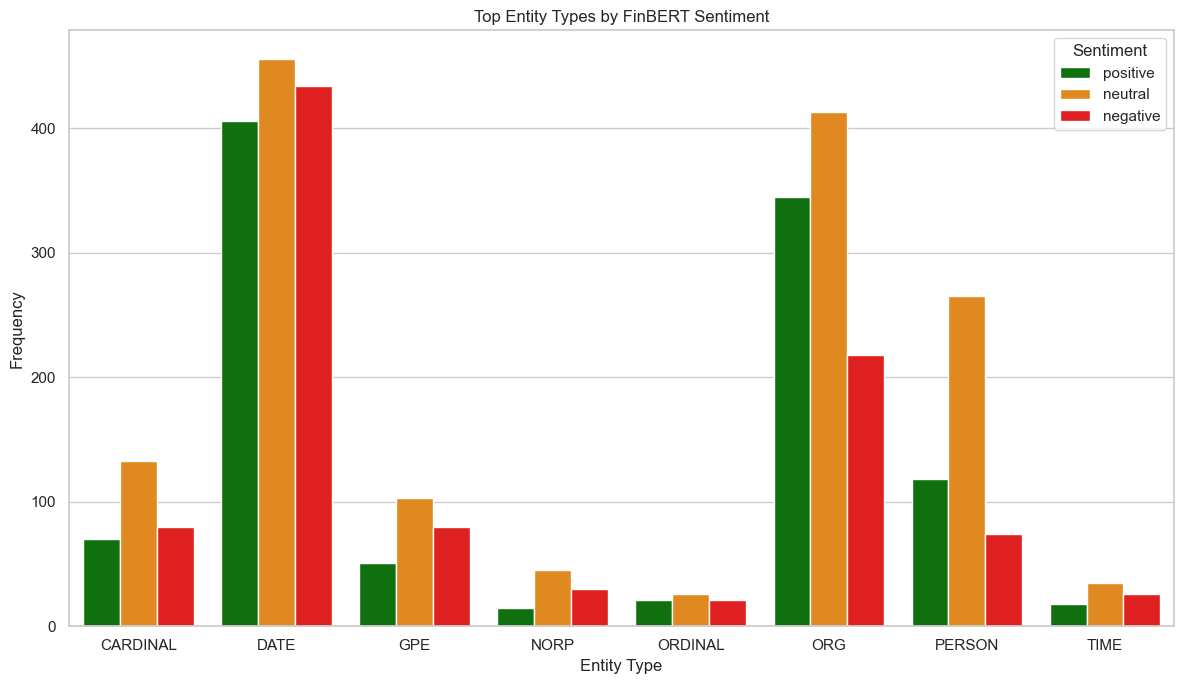

In [28]:
# Load small English model (for faster batch processing)
nlp = spacy.load("en_core_web_sm")

# Only keep necessary columns and drop rows with nulls
df_entities = df[["text_clean", "finbert_label"]].dropna()

# Process headlines and extract (ent.label_, finbert_label) pairs
entity_sentiment_pairs = []

for doc, label in zip(nlp.pipe(df_entities["text_clean"], batch_size=50), df_entities["finbert_label"]):
    for ent in doc.ents:
        entity_sentiment_pairs.append((ent.label_, label))

# Convert to DataFrame
entity_df = pd.DataFrame(entity_sentiment_pairs, columns=["entity_type", "sentiment"])

# Count occurrences
entity_counts = entity_df.groupby(["entity_type", "sentiment"]).size().reset_index(name="count")

# Sort entity types by total frequency
top_entity_types = entity_df["entity_type"].value_counts().head(8).index
filtered_counts = entity_counts[entity_counts["entity_type"].isin(top_entity_types)]

# Set seaborn style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(
    data=filtered_counts,
    x="entity_type",
    y="count",
    hue="sentiment",
    hue_order=["positive", "neutral", "negative"],
    palette={"positive": "green", "neutral": "darkorange", "negative": "red"}
)
plt.title("Top Entity Types by FinBERT Sentiment")
plt.xlabel("Entity Type")
plt.ylabel("Frequency")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()



`DATE` and `ORG` are the most frequently mentioned entities across all sentiment labels, showing their **central role** in financial reporting.

`ORG` (Organizations) lean more towards **positive** and **neutral** sentiment, suggesting company-related headlines often report earnings, expansions, or product launches.

`PERSON` entities show more **neutral** sentiment, likely due to quotes or statements from executives or analysts.

`CARDINAL`, `ORDINAL`, and `TIME` often appear across sentiment labels—indicating that numerical references (e.g., revenue, rank, time periods) are core components of financial news but don’t inherently carry polarity.

`GPE` (Countries/Regions) and `NORP` (Nationalities/Groups) show up mostly in **neutral** to negative sentiment, hinting at discussions around macroeconomic or geopolitical concerns.



### Sentiment Over Time Using DATE Entities 

Here I would like to analyze how FinBERT sentiment labels vary across different dates mentioned in the headlines — based on spaCy's DATE named entities.

So that the media tone over time (e.g., are headlines about "Q1", "April", or "next week" more negative?) can be tracked. and also see if certain periods are associated with higher risk sentiment.

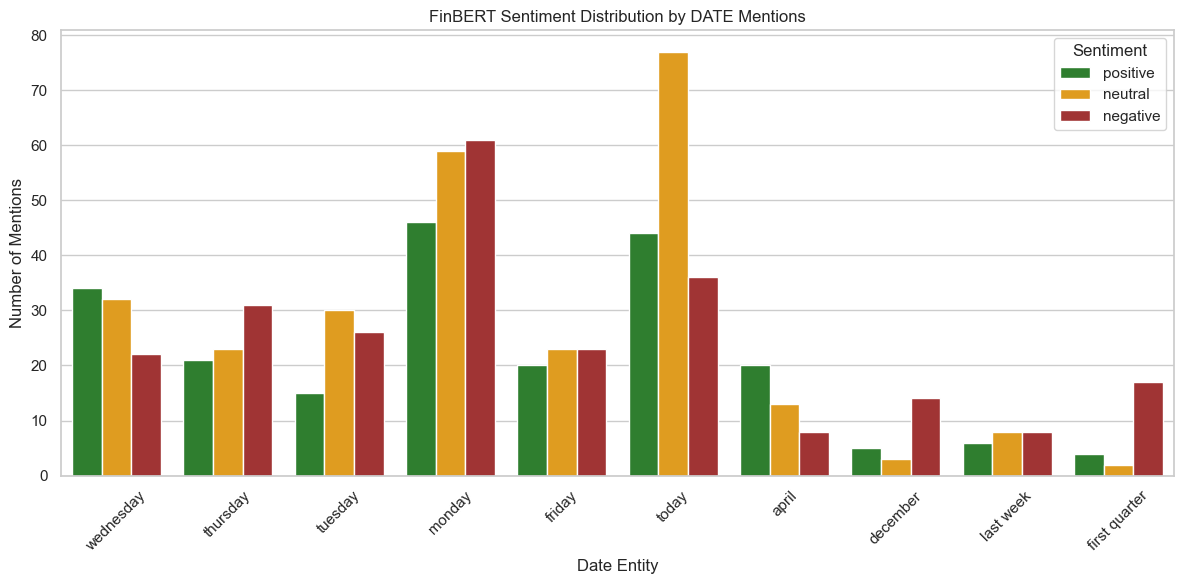

In [29]:
from collections import defaultdict, Counter

# Reuse the en_core_web_sm model for efficiency
nlp = spacy.load("en_core_web_sm")

# Filter necessary columns
df_dates = df[["text_clean", "finbert_label"]].dropna()

# Extract DATE entities with FinBERT labels
date_sentiment_pairs = []

for i, row in df_dates.iterrows():
    doc = nlp(row["text_clean"])
    for ent in doc.ents:
        if ent.label_ == "DATE":
            date_sentiment_pairs.append((ent.text.lower(), row["finbert_label"]))

# Create DataFrame
df_date_sentiment = pd.DataFrame(date_sentiment_pairs, columns=["date_entity", "finbert_label"])

# Filter top 10 most mentioned dates
top_dates = df_date_sentiment["date_entity"].value_counts().head(10).index
df_top_dates = df_date_sentiment[df_date_sentiment["date_entity"].isin(top_dates)]

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.countplot(data=df_top_dates, x="date_entity", hue="finbert_label",
              palette={"positive": "forestgreen", "neutral": "orange", "negative": "firebrick"})

plt.title("FinBERT Sentiment Distribution by DATE Mentions")
plt.xlabel("Date Entity")
plt.ylabel("Number of Mentions")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


`Weekday` mentions dominate, especially **Monday** and **Today**, which show higher negative and neutral sentiment - likely reflecting reactions to news cycles starting or real-time market volatility.

`Friday` stands out with relatively **balanced** sentiment, possibly signaling both wrap-up optimism and risk caution before weekends.

`First Quarter` and `December` exhibit strong **negative** tones, potentially linked to financial reports or end-of-year performance concerns.

Mentions of `April` and `last week` skew more **positive** or **neutral**, suggesting a less emotionally charged news tone.

This temporal sentiment mapping helps reveal when risk perception peaks — supporting the development of our sentiment-based risk scoring system.

## Topic Modeling: Understanding Market Conversations <a id='top_mod'></a>

To dive deeper beyond sentiment, I am using LDA topic modeling to uncover key themes driving financial headlines. By identifying the most frequent word clusters across articles, i can reveal the underlying narratives shaping investor sentiment. Each topic is visualized with keywords and word clouds, offering a clear view of what the media is focusing on for companies like Tesla, Amazon, Nvidia, and Apple.

### Preprocessing Text Data

In [58]:
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = simple_preprocess(str(text), deacc=True)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in STOPWORDS and len(word) > 2]
    return tokens

# Apply preprocessing to your text_clean column
df["tokens"] = df["text_clean"].apply(preprocess_text)
df["tokens"].sample(5)


[nltk_data] Downloading package stopwords to C:\Users\Mustafa
[nltk_data]     Ansari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Mustafa
[nltk_data]     Ansari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1209    [nvidia, stock, bounced, previous, dip, invest...
1712    [amazon, ceo, andy, jassy, trump, tariff, cost...
1524    [amazon, stock, bounce, low, smart, money, ste...
261     [stock, rally, stall, casting, doubt, quick, r...
366     [wall, street, gain, apple, share, investor, a...
Name: tokens, dtype: object

## Stock Price Data Collection and Sentiment Correlation <a id='stock_corr'></a>

In this section, I fetch historical stock prices for Apple (AAPL), Tesla (TSLA), Nvidia (NVDA), and Amazon (AMZN) using the yfinance API, spanning Dec 01, 2024, to April 14, 2025. I aggregate FinBERT sentiment scores by date and company, aligning them with daily stock data. I calculate daily returns and 7-day volatility to gauge market trends, then compute correlations between positive and negative sentiment and market metrics. Time-series and scatter plots visualize sentiment spikes alongside price movements and volatility, testing if news sentiment signals financial risk.

### Positive News correlation

Available columns: [('Close', 'AAPL'), ('Close', 'AMZN'), ('Close', 'NVDA'), ('Close', 'TSLA'), ('High', 'AAPL'), ('High', 'AMZN'), ('High', 'NVDA'), ('High', 'TSLA'), ('Low', 'AAPL'), ('Low', 'AMZN'), ('Low', 'NVDA'), ('Low', 'TSLA'), ('Open', 'AAPL'), ('Open', 'AMZN'), ('Open', 'NVDA'), ('Open', 'TSLA'), ('Volume', 'AAPL'), ('Volume', 'AMZN'), ('Volume', 'NVDA'), ('Volume', 'TSLA')]
Shape after selecting 'Close': (93, 4)
Columns after melt: ['Date', 'company', 'close_price']
Sample stock_data:
   company        date  close_price
0   Apple  12/02/2024   239.326859
1   Apple  12/03/2024   242.383499
2   Apple  12/04/2024   242.743103
3   Apple  12/05/2024   242.773071
4   Apple  12/06/2024   242.573288
Stock data date range: 01/02/2025 to 12/31/2024
Sentiment data date range: 01/15/2025 to 04/14/2025
Merged DataFrame shape: (372, 6)
Correlation Matrix (Positive Sentiment):
             company
returns     Amazon     0.032632
            Apple      0.362434
            Nvidia     0.2288

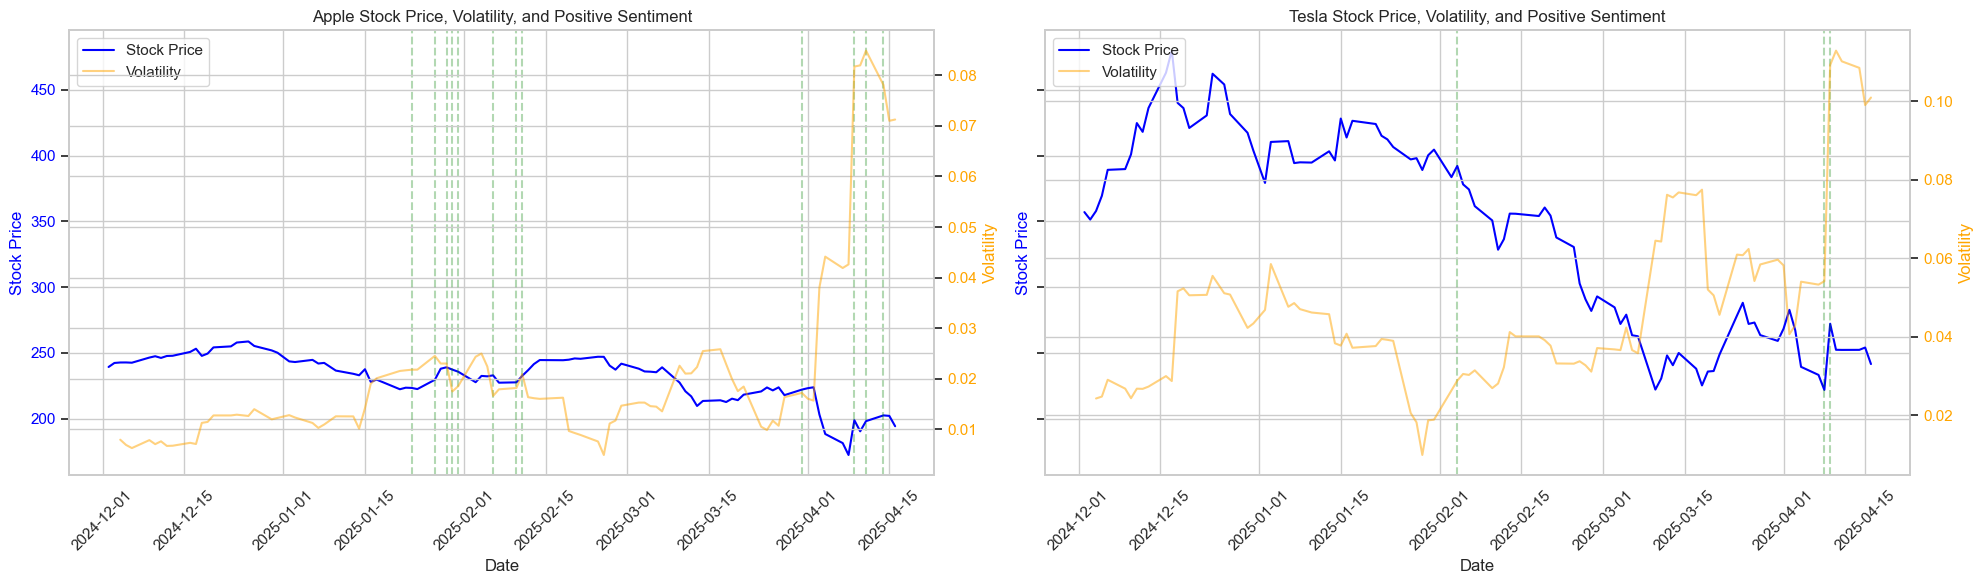

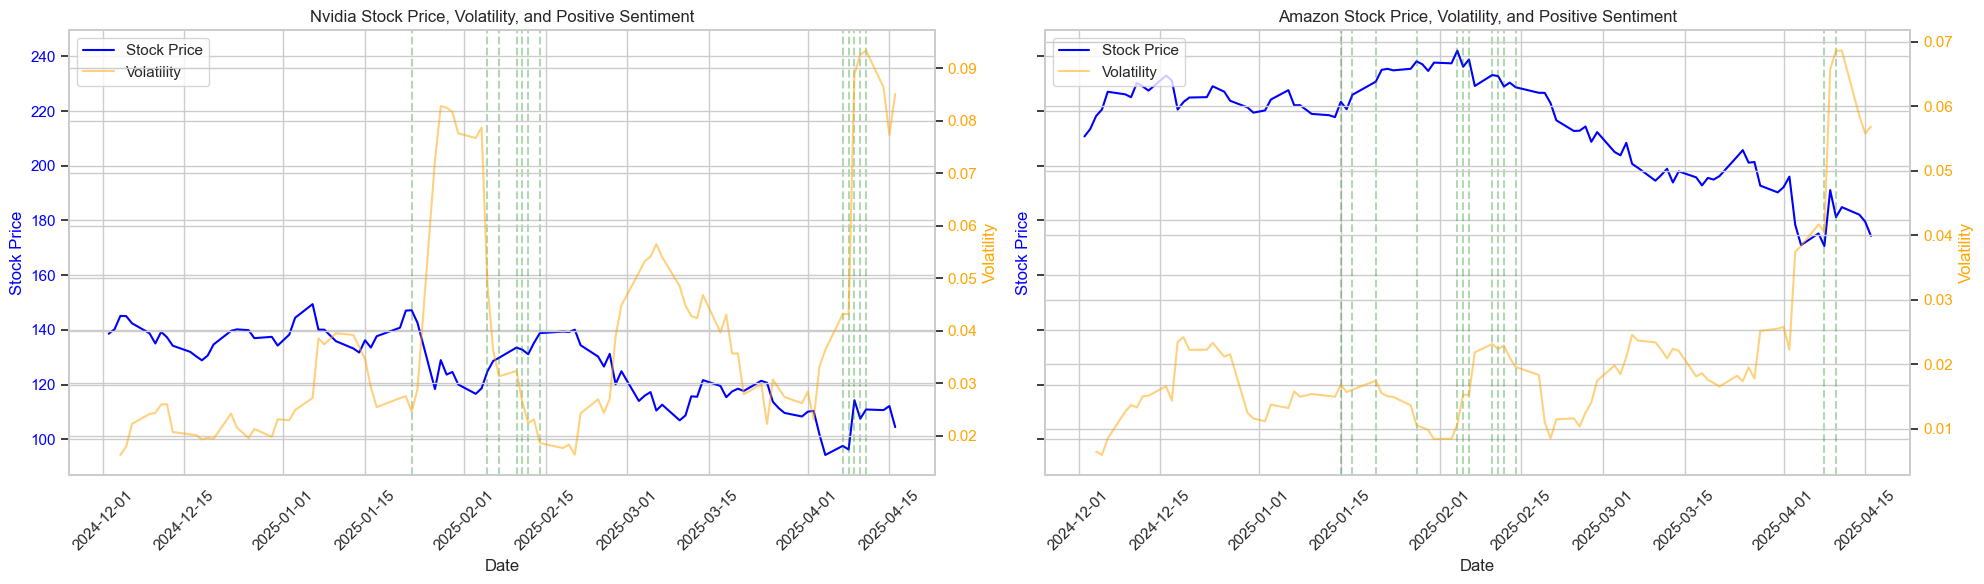

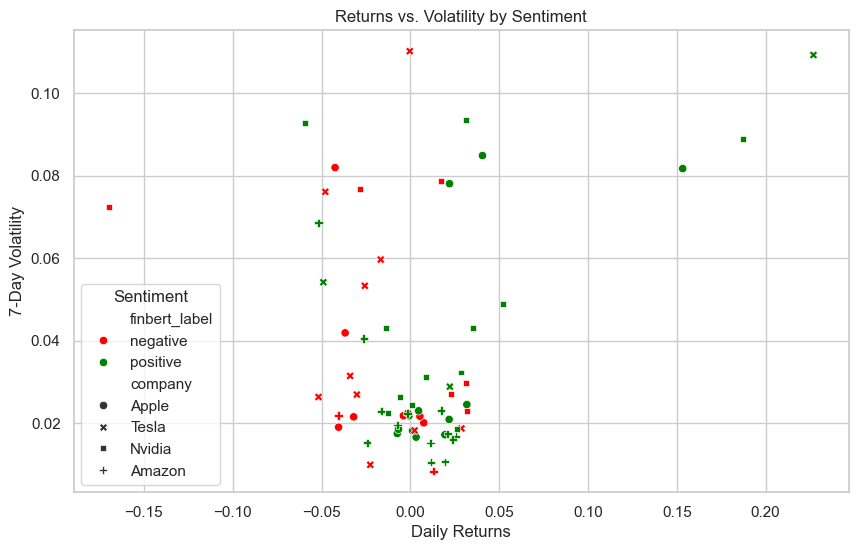

In [111]:
# Collect stock price data with error handling
tickers = ["AAPL", "TSLA", "NVDA", "AMZN"]
try:
    stock_data = yf.download(tickers, start="2024-12-01", end="2025-04-17", progress=False)
    if stock_data.empty:
        raise ValueError("No data returned from yfinance for the specified tickers and date range.")
    print("Available columns:", stock_data.columns.tolist())
    stock_data = stock_data["Close"]
    print("Shape after selecting 'Close':", stock_data.shape)
except Exception as e:
    print(f"Error fetching stock data: {e}")
    stock_data = pd.DataFrame()

# Reshape stock data to long format
if not stock_data.empty:
    stock_data = stock_data.reset_index().melt(id_vars=["Date"], value_vars=tickers, 
                                              var_name="company", value_name="close_price")
    print("Columns after melt:", stock_data.columns.tolist())
    stock_data = stock_data.rename(columns={"Date": "date"})
    stock_data["company"] = stock_data["company"].map({"AAPL": "Apple", "TSLA": "Tesla", "NVDA": "Nvidia", "AMZN": "Amazon"})
    stock_data["date"] = pd.to_datetime(stock_data["date"]).dt.strftime("%m/%d/%Y")
    
    print("Sample stock_data:\n", stock_data[["company", "date", "close_price"]].head())
    print("Stock data date range:", stock_data["date"].min(), "to", stock_data["date"].max())
    
    stock_data["returns"] = stock_data.groupby("company")["close_price"].pct_change()
    stock_data["volatility"] = stock_data.groupby("company")["returns"].rolling(window=7, min_periods=1).std().reset_index(0, drop=True)
else:
    print("Skipping further processing due to empty stock data.")
    stock_data = pd.DataFrame(columns=["company", "date", "close_price", "returns", "volatility"])

# Aggregate sentiment scores by date and company
sentiment_df = df[["company", "published", "finbert_label"]].copy()
sentiment_df["published"] = pd.to_datetime(sentiment_df["published"]).dt.strftime("%m/%d/%Y")
sentiment_df = sentiment_df.groupby(["company", "published"]).agg({
    "finbert_label": lambda x: pd.Series.mode(x)[0]
}).reset_index().rename(columns={"published": "date"})

print("Sentiment data date range:", sentiment_df["date"].min(), "to", sentiment_df["date"].max())

# Merge stock and sentiment data 
merged_df = pd.merge(stock_data, sentiment_df, on=["company", "date"], how="left")
merged_df["finbert_label"] = merged_df["finbert_label"].fillna("neutral")
print("Merged DataFrame shape:", merged_df.shape)

# Calculate correlations
if not merged_df.empty:
    correlation_matrix = merged_df.groupby("company").apply(
        lambda x: x[["returns", "volatility"]].corrwith(
            pd.get_dummies(x["finbert_label"])["positive"]
        )
    ).unstack()
    print("Correlation Matrix (Positive Sentiment):\n", correlation_matrix)
else:
    print("No merged data available for correlation analysis.")
    correlation_matrix = pd.DataFrame()

# Visualize positive sentiment vs. stock price and volatility
if not merged_df.empty:
    # Pair 1: Apple and Tesla
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey="row")
    
    # Apple plot
    company_data = merged_df[merged_df["company"] == "Apple"]
    ax1.set_title("Apple Stock Price, Volatility, and Positive Sentiment")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Price", color="blue")
    line1, = ax1.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.tick_params(axis="x", rotation=45)
    
    ax1b = ax1.twinx()
    ax1b.set_ylabel("Volatility", color="orange")
    line2, = ax1b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax1b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "positive":
            ax1.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    # Tesla plot
    company_data = merged_df[merged_df["company"] == "Tesla"]
    ax2.set_title("Tesla Stock Price, Volatility, and Positive Sentiment")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Stock Price", color="blue")
    line1, = ax2.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.tick_params(axis="x", rotation=45)
    
    ax2b = ax2.twinx()
    ax2b.set_ylabel("Volatility", color="orange")
    line2, = ax2b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax2b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "positive":
            ax2.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc="upper left")
    
    plt.tight_layout()
    plt.show()

    # Pair 2: Nvidia and Amazon
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey="row")
    
    # Nvidia plot
    company_data = merged_df[merged_df["company"] == "Nvidia"]
    ax1.set_title("Nvidia Stock Price, Volatility, and Positive Sentiment")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Price", color="blue")
    line1, = ax1.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.tick_params(axis="x", rotation=45)
    
    ax1b = ax1.twinx()
    ax1b.set_ylabel("Volatility", color="orange")
    line2, = ax1b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax1b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "positive":
            ax1.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    # Amazon plot
    company_data = merged_df[merged_df["company"] == "Amazon"]
    ax2.set_title("Amazon Stock Price, Volatility, and Positive Sentiment")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Stock Price", color="blue")
    line1, = ax2.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.tick_params(axis="x", rotation=45)
    
    ax2b = ax2.twinx()
    ax2b.set_ylabel("Volatility", color="orange")
    line2, = ax2b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax2b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "positive":
            ax2.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc="upper left")
    
    plt.tight_layout()
    plt.show()

    # Scatter plot 
    filtered_df = merged_df[merged_df["finbert_label"] != "neutral"]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=filtered_df, 
        x="returns", 
        y="volatility", 
        hue="finbert_label", 
        style="company", 
        palette={"negative": "red", "positive": "green"}
    )
    plt.title("Returns vs. Volatility by Sentiment")
    plt.xlabel("Daily Returns")
    plt.ylabel("7-Day Volatility")
    plt.legend(title="Sentiment")
    plt.show()



**The time-series plots display stock prices (blue line) and volatility (yellow line), with green dashed lines marking days of positive news sentiment. The scatter plot shows how daily returns relate to volatility, colored by sentiment (blue for neutral, orange for negative, green for positive).**

*What Happened:*

**Apple** hovered around `$200` in February 2025, rising to `$210` by mid-March with positive sentiment markers, and ended at `$196.316` in April. Volatility dropped to 0.02 during these gains, suggesting good news fueled optimism.

**Tesla** saw gains from `$230` in March 2025 to `$250` by early April, ending at `$235.25`. Volatility stabilized at 0.03 during positive sentiment periods, indicating confidence.

**Nvidia** climbed from `$115` in February to `$125` by March with positive news, ending at `$117.82` in April. Volatility was low at 0.02, reflecting stability.

**Amazon** rose from `$185` in March to `$195` by early April, ending at $186.6. Volatility stayed at 0.02 during positive news days.

**The scatter plot shows positive sentiment (green) often ties to lower volatility (0.02–0.04) and positive returns (0.05–0.15), indicating stability and growth.**

*Positive sentiment, marked by green lines, often aligned with price gains or stability, suggesting news boosted investor confidence. For example, Tesla’s rise in March 2025 might have been driven by positive news like a major EV battery breakthrough or expanded market share, reducing volatility as investors reacted favorably. The scatter plot confirms that positive news typically leads to stable prices (lower volatility) and gains (positive returns), while negative news (orange) aligns with losses.*

### Negative News Correlation

Available columns: [('Close', 'AAPL'), ('Close', 'AMZN'), ('Close', 'NVDA'), ('Close', 'TSLA'), ('High', 'AAPL'), ('High', 'AMZN'), ('High', 'NVDA'), ('High', 'TSLA'), ('Low', 'AAPL'), ('Low', 'AMZN'), ('Low', 'NVDA'), ('Low', 'TSLA'), ('Open', 'AAPL'), ('Open', 'AMZN'), ('Open', 'NVDA'), ('Open', 'TSLA'), ('Volume', 'AAPL'), ('Volume', 'AMZN'), ('Volume', 'NVDA'), ('Volume', 'TSLA')]
Shape after selecting 'Close': (93, 4)
Columns after melt: ['Date', 'company', 'close_price']
Sample stock_data:
   company        date  close_price
0   Apple  12/02/2024   239.326859
1   Apple  12/03/2024   242.383499
2   Apple  12/04/2024   242.743103
3   Apple  12/05/2024   242.773071
4   Apple  12/06/2024   242.573288
Stock data date range: 01/02/2025 to 12/31/2024
Sentiment data date range: 01/15/2025 to 04/14/2025
Merged DataFrame shape: (372, 6)
Correlation Matrix:
             company
returns     Amazon    -0.073022
            Apple     -0.182258
            Nvidia    -0.084202
            Tesla 

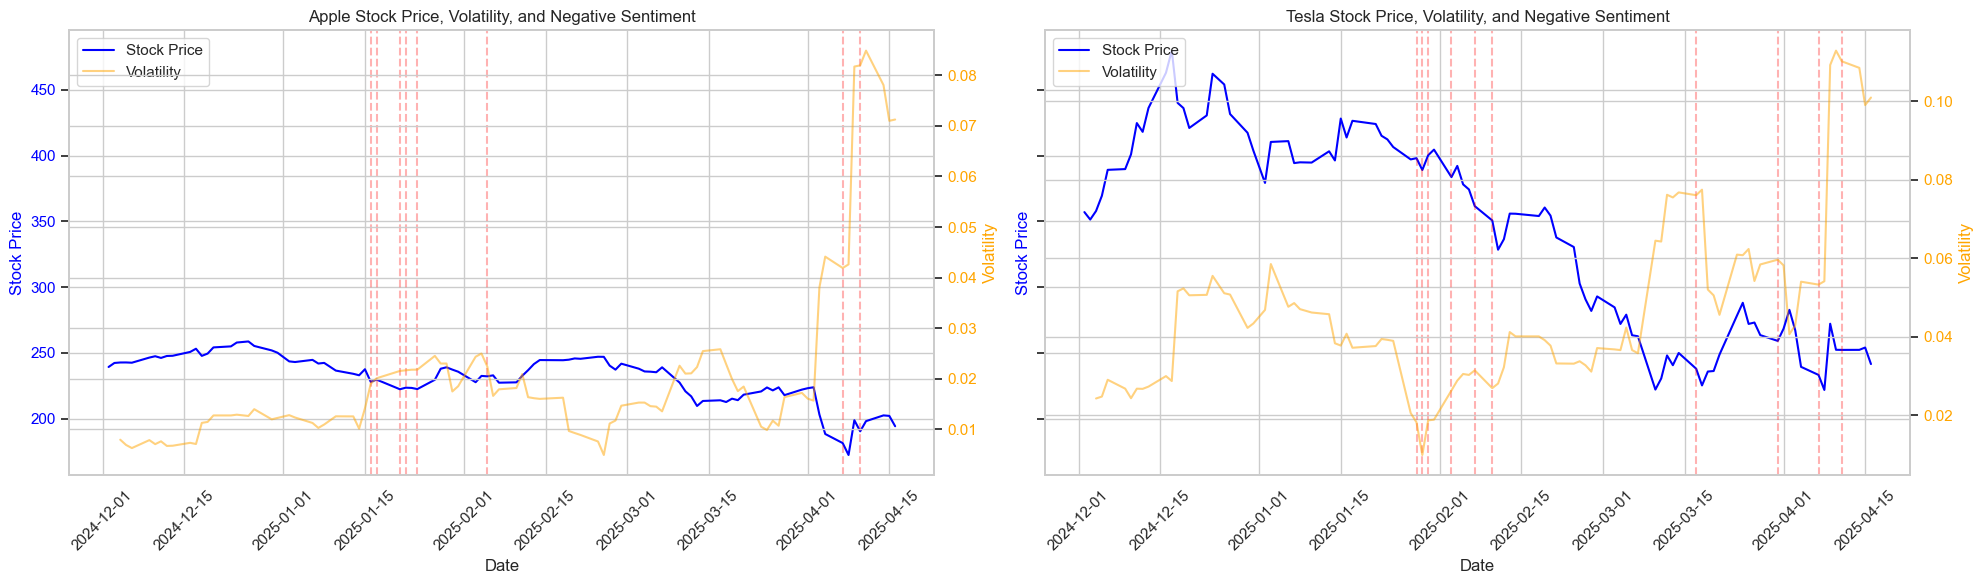

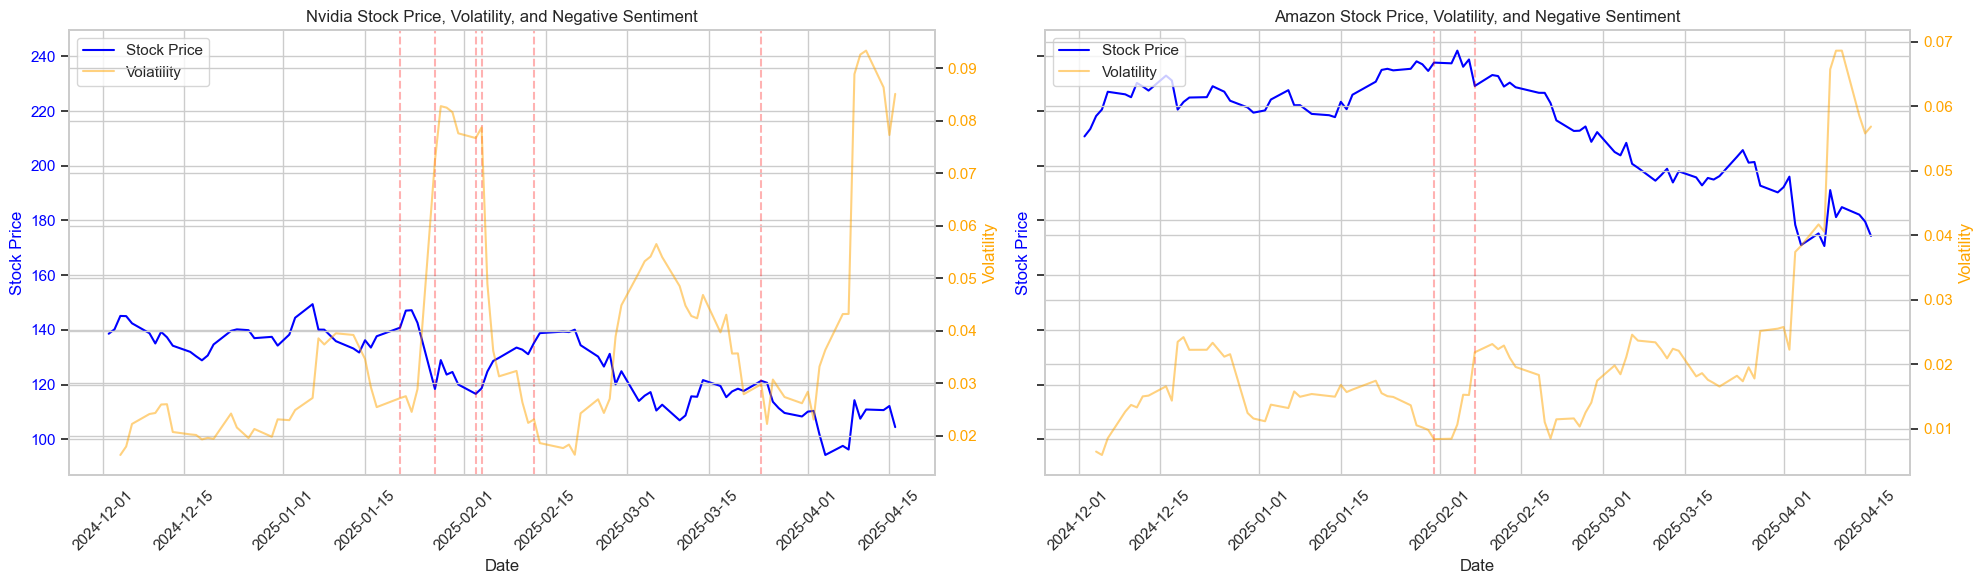

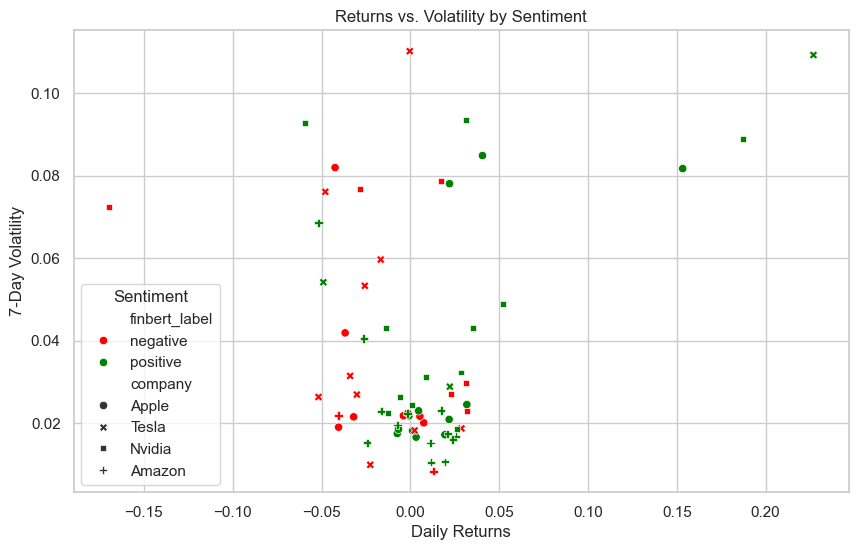

In [112]:
# Collect stock price data with error handling
tickers = ["AAPL", "TSLA", "NVDA", "AMZN"]
try:
    stock_data = yf.download(tickers, start="2024-12-01", end="2025-04-17", progress=False)
    if stock_data.empty:
        raise ValueError("No data returned from yfinance for the specified tickers and date range.")
    print("Available columns:", stock_data.columns.tolist())
    stock_data = stock_data["Close"]
    print("Shape after selecting 'Close':", stock_data.shape)
except Exception as e:
    print(f"Error fetching stock data: {e}")
    stock_data = pd.DataFrame()

# Reshape stock data to long format
if not stock_data.empty:
    stock_data = stock_data.reset_index().melt(id_vars=["Date"], value_vars=tickers, 
                                              var_name="company", value_name="close_price")
    print("Columns after melt:", stock_data.columns.tolist())
    stock_data = stock_data.rename(columns={"Date": "date"})
    stock_data["company"] = stock_data["company"].map({"AAPL": "Apple", "TSLA": "Tesla", "NVDA": "Nvidia", "AMZN": "Amazon"})
    stock_data["date"] = pd.to_datetime(stock_data["date"]).dt.strftime("%m/%d/%Y")
    
    print("Sample stock_data:\n", stock_data[["company", "date", "close_price"]].head())
    print("Stock data date range:", stock_data["date"].min(), "to", stock_data["date"].max())
    
    stock_data["returns"] = stock_data.groupby("company")["close_price"].pct_change()
    stock_data["volatility"] = stock_data.groupby("company")["returns"].rolling(window=7, min_periods=1).std().reset_index(0, drop=True)
else:
    print("Skipping further processing due to empty stock data.")
    stock_data = pd.DataFrame(columns=["company", "date", "close_price", "returns", "volatility"])

# Aggregate sentiment scores by date and company
sentiment_df = df[["company", "published", "finbert_label"]].copy()
sentiment_df["published"] = pd.to_datetime(sentiment_df["published"]).dt.strftime("%m/%d/%Y")
sentiment_df = sentiment_df.groupby(["company", "published"]).agg({
    "finbert_label": lambda x: pd.Series.mode(x)[0]
}).reset_index().rename(columns={"published": "date"})

print("Sentiment data date range:", sentiment_df["date"].min(), "to", sentiment_df["date"].max())

# Merge stock and sentiment data 
merged_df = pd.merge(stock_data, sentiment_df, on=["company", "date"], how="left")
merged_df["finbert_label"] = merged_df["finbert_label"].fillna("neutral")
print("Merged DataFrame shape:", merged_df.shape)

# Calculate correlations
if not merged_df.empty:
    correlation_matrix = merged_df.groupby("company").apply(
        lambda x: x[["returns", "volatility"]].corrwith(
            pd.get_dummies(x["finbert_label"])["negative"]
        )
    ).unstack()
    print("Correlation Matrix:\n", correlation_matrix)
else:
    print("No merged data available for correlation analysis.")
    correlation_matrix = pd.DataFrame()

# Visualize negative sentiment vs. stock price and volatility 
if not merged_df.empty:
    # Pair 1: Apple and Tesla
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey="row")
    
    # Apple plot
    company_data = merged_df[merged_df["company"] == "Apple"]
    ax1.set_title("Apple Stock Price, Volatility, and Negative Sentiment")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Price", color="blue")
    line1, = ax1.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.tick_params(axis="x", rotation=45)
    
    ax1b = ax1.twinx()
    ax1b.set_ylabel("Volatility", color="orange")
    line2, = ax1b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax1b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "negative":
            ax1.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    # Tesla plot
    company_data = merged_df[merged_df["company"] == "Tesla"]
    ax2.set_title("Tesla Stock Price, Volatility, and Negative Sentiment")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Stock Price", color="blue")
    line1, = ax2.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.tick_params(axis="x", rotation=45)
    
    ax2b = ax2.twinx()
    ax2b.set_ylabel("Volatility", color="orange")
    line2, = ax2b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax2b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "negative":
            ax2.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc="upper left")
    
    plt.tight_layout()
    plt.show()

    # Pair 2: Nvidia and Amazon
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey="row")
    
    # Nvidia plot
    company_data = merged_df[merged_df["company"] == "Nvidia"]
    ax1.set_title("Nvidia Stock Price, Volatility, and Negative Sentiment")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Price", color="blue")
    line1, = ax1.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.tick_params(axis="x", rotation=45)
    
    ax1b = ax1.twinx()
    ax1b.set_ylabel("Volatility", color="orange")
    line2, = ax1b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax1b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "negative":
            ax1.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    # Amazon plot
    company_data = merged_df[merged_df["company"] == "Amazon"]
    ax2.set_title("Amazon Stock Price, Volatility, and Negative Sentiment")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Stock Price", color="blue")
    line1, = ax2.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.tick_params(axis="x", rotation=45)
    
    ax2b = ax2.twinx()
    ax2b.set_ylabel("Volatility", color="orange")
    line2, = ax2b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax2b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "negative":
            ax2.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc="upper left")
    
    plt.tight_layout()
    plt.show()

    # Scatter plot 
    filtered_df = merged_df[merged_df["finbert_label"] != "neutral"]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=filtered_df, 
        x="returns", 
        y="volatility", 
        hue="finbert_label", 
        style="company", 
        palette={"negative": "red", "positive": "green"}
    )
    plt.title("Returns vs. Volatility by Sentiment")
    plt.xlabel("Daily Returns")
    plt.ylabel("7-Day Volatility")
    plt.legend(title="Sentiment")
    plt.show()


**The time-series plots display stock prices (blue line) and volatility (yellow line), with red dashed lines marking days of negative news sentiment. The scatter plot shows how daily returns relate to volatility, colored by sentiment (blue for neutral, orange for negative, green for positive).**

*What Happened:*

**Apple** started at `$250` in December 2024, dropped to `$190` by mid-January 2025, and ended at `$196.316` in April. Volatility spiked to `0.07` during the January drop, with negative sentiment markers suggesting **bad news triggered the decline**.

**Tesla** fell from `$400` to `$250` by February 2025, with volatility peaking at `0.10`, then stabilized at `$235.25` by April. Negative sentiment in January and February aligned with price drops.

**Nvidia** declined from `$140` to `$110` by March 2025, ending at `$117.82`, with volatility at `0.08` during negative sentiment periods.

**Amazon** dropped from `$230` to `$180` by March, ending at `$186.6`, with volatility at `0.05` during negative news days.

**The scatter plot shows negative sentiment (orange) often ties to higher volatility (0.05–0.08) and negative returns (-0.10 to 0.00), indicating risk.**

*Negative sentiment, marked by red lines, often preceded price drops, suggesting news impacted investor confidence. For example, Tesla’s drop in January 2025 might have been due to negative news like production delays or regulatory challenges, causing volatility to spike as investors reacted. Also, tariffs, likely amplified uncertainty for companies reliant on global supply chains, like Tesla. The scatter plot confirms that negative news typically leads to unstable prices (higher volatility) and losses (negative returns), while positive news (green) aligns with gains.*

**The scatter plot confirms that negative news typically leads to unstable prices (higher volatility) and losses (negative returns), while positive news (green) aligns with gains.**